# Knowledge Graph

Often times, data is messy and not always stored in a structured manner ready for use by an LLM. In this recipe, we show how to create a knowledge graph from an unstructured document using common python libraries and Mirascope using OpenAI GPT-4o-mini.

<div class="admonition tip">
<p class="admonition-title">Mirascope Concepts Used</p>
<ul>
<li><a href="../../../learn/prompts/">Prompts</a></li>
<li><a href="../../../learn/calls/">Calls</a></li>
<li><a href="../../../learn/response_models/">Response Models</a></li>
</ul>
</div>

<div class="admonition note">
<p class="admonition-title">Background</p>
<p>
While traditional Natural Language Processing (NLP) techniques have long been used in knowledge graphs to identify entities and relationships in unstructured text, Large Language Models (LLMs) have significantly improved this process. LLMs enhance the accuracy of entity identification and linking to knowledge graph entries, demonstrating superior ability to handle context and ambiguity compared to conventional NLP methods. 
</p>
</div>

## Setup

To set up our environment, first let's install all of the packages we will use:

In [ ]:
!pip install "mirascope[openai]"
# (Optional) For visualization
!pip install matplotlib networkx
# (Optional) For parsing HTML
!pip install beautifulsoup4

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"
# Set the appropriate API key for the provider you're using


## Create the `KnowledgeGraph`

The first step is to create a `KnowledgeGraph` with `Nodes` and `Edges` that represent our entities and relationships. For our simple recipe, we will use a Pydantic `BaseModel` to represent our `KnowledgeGraph`:



In [1]:
from pydantic import BaseModel, Field


class Edge(BaseModel):
    source: str = Field(..., description="The source node of the edge")
    target: str = Field(..., description="The target node of the edge")
    relationship: str = Field(
        ..., description="The relationship between the source and target nodes"
    )


class Node(BaseModel):
    id: str = Field(..., description="The unique identifier of the node")
    type: str = Field(..., description="The type or label of the node")
    properties: dict | None = Field(
        ..., description="Additional properties and metadata associated with the node"
    )


class KnowledgeGraph(BaseModel):
    nodes: list[Node] = Field(..., description="List of nodes in the knowledge graph")
    edges: list[Edge] = Field(..., description="List of edges in the knowledge graph")


Our `Edge` represents connections between nodes, with attributes for the source node, target node, and the relationship between them. While our `Node` defines nodes with an ID, type, and optional properties. Our `KnowledgeGraph` then aggregates these nodes and edges into a comprehensive knowledge graph.

Now that we have our schema defined, it's time to create our knowledge graph.

## Creating the knowledge graph

We start off with engineering our prompt, prompting the LLM to create a knowledge graph based on the user query. Then we are taking a [Wikipedia](https://en.wikipedia.org/wiki/Large_language_model) article and converting the raw text into a structured knowledge graph.
The command below will download the article to your local machine by using the `curl` command. If you don't have `curl` installed, you can download the article manually from the link above and save it as `wikipedia.html`.

In [ ]:
!curl https://en.wikipedia.org/wiki/Large_language_model -o wikipedia.html

{% raw %}

In [5]:
from bs4 import BeautifulSoup
from mirascope.core import openai, prompt_template


def get_text_from_html(file_path: str) -> str:
    with open(file_path) as file:
        html_text = file.read()
    return BeautifulSoup(html_text, "html.parser").get_text()


@openai.call(model="gpt-4o-mini", response_model=KnowledgeGraph)
@prompt_template(
    """
    SYSTEM:
    Your job is to create a knowledge graph based on the text and user question.
    
    The article:
    {text}

    Example:
    John and Jane Doe are siblings. Jane is 25 and 5 years younger than John.
    Node(id="John Doe", type="Person", properties={{"age": 30}})
    Node(id="Jane Doe", type="Person", properties={{"age": 25}})
    Edge(source="John Doe", target="Jane Doe", relationship="Siblings")

    USER:
    {question}
    """
)
def generate_knowledge_graph(
    question: str, file_name: str
) -> openai.OpenAIDynamicConfig:
    text = get_text_from_html(file_name)
    return {"computed_fields": {"text": text}}


question = "What are the pitfalls of using LLMs?"

kg = generate_knowledge_graph(question, "wikipedia.html")
print(kg)

nodes=[Node(id='Large Language Models', type='Large Language Model', properties=None), Node(id='Data Cleaning Issues', type='Pitfall', properties=None), Node(id='Bias Inheritance', type='Pitfall', properties=None), Node(id='Hallucinations', type='Pitfall', properties=None), Node(id='Limited Understanding', type='Pitfall', properties=None), Node(id='Dependence on Training Data', type='Pitfall', properties=None), Node(id='Security Risks', type='Pitfall', properties=None), Node(id='Stereotyping', type='Pitfall', properties=None), Node(id='Political Bias', type='Pitfall', properties=None)] edges=[Edge(source='Large Language Models', target='Data Cleaning Issues', relationship='has pitfall'), Edge(source='Large Language Models', target='Bias Inheritance', relationship='has pitfall'), Edge(source='Large Language Models', target='Hallucinations', relationship='has pitfall'), Edge(source='Large Language Models', target='Limited Understanding', relationship='has pitfall'), Edge(source='Large La

{% endraw %}

We engineer our prompt by giving examples of how the properties should be filled out and use Mirascope's `DynamicConfig` to pass in the article. While it seems silly in this context, there may be multiple documents that you may want to conditionally pass in depending on the query. This can include text chunks from a Vector Store or data from a Database.

After we generated our knowledge graph, it is time to create our `run` function


In [6]:
@openai.call(model="gpt-4o-mini")
@prompt_template(
    """
    SYSTEM:
    Answer the following question based on the knowledge graph.

    Knowledge Graph:
    {knowledge_graph}
    
    USER:
    {question}
    """
)
def run(question: str, knowledge_graph: KnowledgeGraph): ...

We define a simple `run` function that answers the users query based on the knowledge graph. Combining knowledge graphs with semantic search will lead to the LLM having better context to address complex questions.


In [7]:
print(run(question, kg))

The pitfalls of using Large Language Models (LLMs) include:

1. Data Cleaning Issues
2. Bias Inheritance
3. Hallucinations
4. Limited Understanding
5. Dependence on Training Data
6. Security Risks
7. Stereotyping
8. Political Bias


## Render your graph

Optionally, to visualize the knowledge graph, we use networkx and matplotlib to draw the edges and nodes.



Matplotlib is building the font cache; this may take a moment.


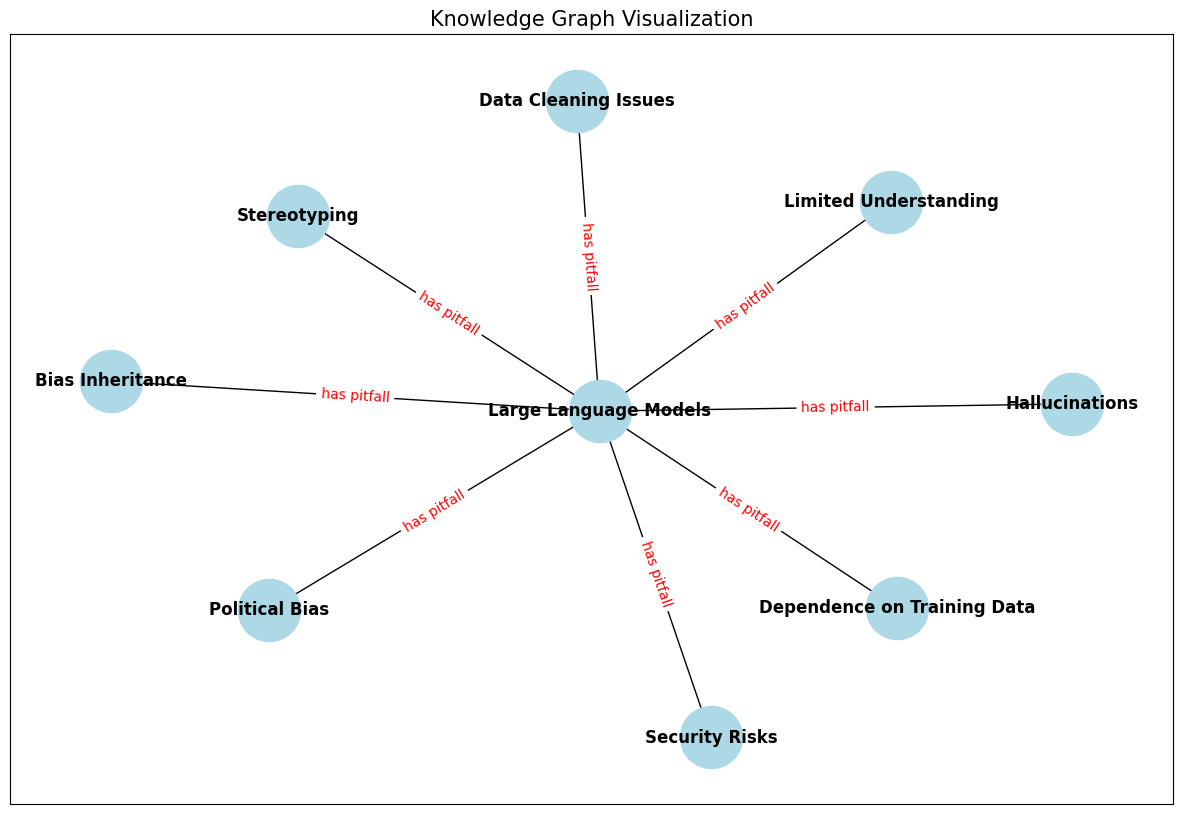

In [8]:
import matplotlib.pyplot as plt
import networkx as nx


def render_graph(kg: KnowledgeGraph):
    G = nx.DiGraph()

    for node in kg.nodes:
        G.add_node(node.id, label=node.type, **(node.properties or {}))

    for edge in kg.edges:
        G.add_edge(edge.source, edge.target, label=edge.relationship)

    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph Visualization", fontsize=15)
    plt.show()


question = "What are the pitfalls of using LLMs?"
render_graph(kg)

<div class="admonition tip">
<p class="admonition-title">Additional Real-World Applications</p>
<ol>
<li><p><b>Enhance your Q&A</b></p>
<ul>
<li>Customer support system uses knowledge graph containing information about products to answer questions.</li>
<li>Example: "Does the Mirascope phone support fast charging?" The knowledge graph has a node "Mirascope smartphone" and searches "support" edge to find fast charging and returns results for the LLM to use.</li>
</ul>
</li>
<li><p><b>Supply Chain Optimization</b></p>
<ul>
<li>A knowledge graph could represent complex relationships between suppliers, manufacturing plants, distribution centers, products, and transportation routes.</li>
<li>Example: How would a 20% increase in demand for a mirascope affect our inventory needs and shipping costs? Use knowledge graph to trace the mirascope toy, calculate inventory, and then estimate shipping costs and return results for the LLM to give a report.</li>
</ul>
</li>
<li><p><b>Healthcare Assistant</b></p>
<ul>
<li>Assuming no PII or HIPPA violation, build a knowledge graph from patient remarks.</li>
<li>Example: "Mary said help, I've fallen". Build up a knowledge graph from comments and use an LLM to scan the node "Mary" for any worrying activity. Have the LLM alert Healthcare employees that there may be an emergency.</li>
</ul>
</li>
</ol>
</div>

When adapting this recipe, consider:

- Combining knowledge graph with Text Embeddings for both structured search and semantic search, depending on your requirements.
- Store your knowledge graph in a database / cache for faster retrieval.
- Experiment with different LLM models, some may be better than others for generating the knowledge graph.
- Turn the example into an Agentic workflow, giving it access to tools such as web search so the LLM can call tools to update its own knowledge graph to answer any question.
- Adding Pydantic `AfterValidators` to prevent duplicate Node IDs.

